In [64]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")#忽视所有warning

In [65]:
dis_data=pd.read_excel('demo/data/discdata.xls',encoding='gbk')

In [3]:
dis_data.head()

,SYS_NAME,NAME,TARGET_ID,DESCRIPTION,ENTITY,VALUE,COLLECTTIME
0,财务管理系统,CWXT_DB,184,磁盘已使用大小,C:\,3.427079e+07,2014-10-01
1,财务管理系统,CWXT_DB,184,磁盘已使用大小,D:\,8.026259e+07,2014-10-01
2,财务管理系统,CWXT_DB,183,磁盘容量,C:\,5.232332e+07,2014-10-01
3,财务管理系统,CWXT_DB,183,磁盘容量,D:\,1.572833e+08,2014-10-01
4,财务管理系统,CWXT_DB,184,磁盘已使用大小,C:\,3.432890e+07,2014-10-02


In [6]:
#磁盘容量不变，提取并去重
dis_capacity=dis_data.loc[dis_data['TARGET_ID']==183,['SYS_NAME','NAME','TARGET_ID','DESCRIPTION','ENTITY','VALUE']].drop_duplicates()
dis_capacity.head()

,SYS_NAME,NAME,TARGET_ID,DESCRIPTION,ENTITY,VALUE
2,财务管理系统,CWXT_DB,183,磁盘容量,C:\,52323324.0
3,财务管理系统,CWXT_DB,183,磁盘容量,D:\,157283328.0


In [14]:
dis_data['TARGET_ID'].unique()

array([184, 183], dtype=int64)

In [83]:
dis_use=dis_data.loc[dis_data['TARGET_ID']==184]
dis_use_t=dis_use.pivot(index='COLLECTTIME',columns='ENTITY',values='VALUE').reset_index()

In [27]:
dis_use_t.head()

ENTITY,COLLECTTIME,C:\,D:\
0,2014-10-01,34270787.33,80262592.65
1,2014-10-02,34328899.02,83200151.65
2,2014-10-03,34327553.50,83208320.00
3,2014-10-04,34288672.21,83099271.65
4,2014-10-05,34190978.41,82765171.65


In [26]:
len(dis_use_t)

47

In [20]:
#=====改进表格准换方法=========
#这里由于每个磁盘在一个时间只统计一次，所以直接用上述pivot函数没有问题
#但如果同一时间统计多次，就需要先按统计时间进行分组求和，再变换表格
group=dis_use.groupby(['COLLECTTIME','ENTITY'])
dis_use_1=group.sum().reset_index()
dis_use_1.head()

,COLLECTTIME,ENTITY,TARGET_ID,VALUE
0,2014-10-01,C:\,184,34270787.33
1,2014-10-01,D:\,184,80262592.65
2,2014-10-02,C:\,184,34328899.02
3,2014-10-02,D:\,184,83200151.65
4,2014-10-03,C:\,184,34327553.50


In [25]:
dis_use_1=dis_use_1.pivot(index='COLLECTTIME',columns='ENTITY',values='VALUE').reset_index()
dis_use_1.head()

ENTITY,COLLECTTIME,C:\,D:\
0,2014-10-01,34270787.33,80262592.65
1,2014-10-02,34328899.02,83200151.65
2,2014-10-03,34327553.50,83208320.00
3,2014-10-04,34288672.21,83099271.65
4,2014-10-05,34190978.41,82765171.65


In [28]:
len(dis_use_1)

47

In [42]:
dis_use_t.columns=['COLLECTTIME','C_used','D_used']
dis_use_t.to_csv('dis_used.csv',index=False)

# 平稳性检验

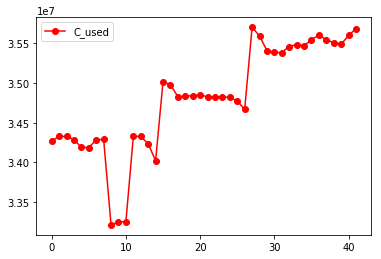

In [85]:
dis_use_t=pd.read_csv('dis_used.csv')
dis_use_train=dis_use_t.iloc[:len(dis_use_t)-5]#将后5行数据留作验证集
#根据时序图可以看出C盘和D盘的使用容量均不是平稳的
import matplotlib.pyplot as plt
dis_use_train[['C_used']].plot(style=['r-o'])
plt.show()

<function matplotlib.pyplot.show>

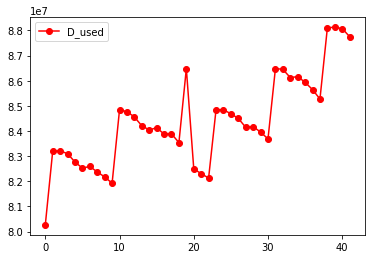

In [50]:
dis_use_train[['D_used']].plot(style=['r-o'])
plt.show

In [53]:
from statsmodels.tsa.stattools import adfuller as ADF
def smooth_test(time_data):
    diff=0
    adf=ADF(time_data)#单位根检验
    while adf[1]>=0.05:#p值（adf[1]）小于0.05，则认为是平稳的[原假设p-1=0,其中xt+1=(p-1)xt+u,若p为1z则为随机游走，不平稳]
        diff=diff+1
        adf=ADF(time_data.diff(diff).dropna())
    print('原始序列经过%s阶差分后平稳，p值为%s' %(diff,adf[1]))

In [56]:
#C盘和D盘均经过一阶差分后平稳
smooth_test(dis_use_train['C_used'])
smooth_test(dis_use_train['D_used'])

原始序列经过1阶差分后平稳，p值为9.57297559233316e-07
原始序列经过1阶差分后平稳，p值为4.792591263393756e-07


<function matplotlib.pyplot.show>

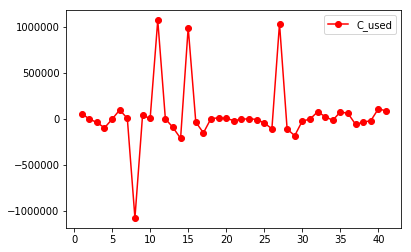

In [57]:
#C盘一阶差分后时序图：除了几个异常点外，其他平稳
dis_use_train[['C_used']].diff(1).plot(style=['r-o'])
plt.show

<function matplotlib.pyplot.show>

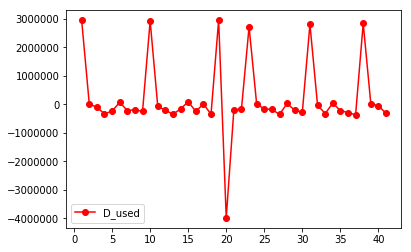

In [58]:
#D盘一阶差分后时序图
dis_use_train[['D_used']].diff(1).plot(style=['r-o'])
plt.show

# 白噪声检验（数据之间是否相互独立）

In [67]:
from statsmodels.stats.diagnostic import acorr_ljungbox
def diagnoise_test(time_data):
    [[lb],[p]]=acorr_ljungbox(time_data,lags=1)#原假设序列值之间相互独立
    if p<0.05:
        print('序列不是白噪声序列，对应p值为%s' %p)#拒绝原假设，序列之间存在相关性
    else:
        print('序列为白噪声序列，对应p值为%s' %p)

In [9]:
diagnoise_test(dis_use_train['C_used'].dropna(),lag=1)#C盘一阶滞后序列不是白噪声，可以用时间序列模型

序列不是白噪声序列，对应p值为1.0609907508070775e-08


In [10]:
diagnoise_test(dis_use_train['D_used'].dropna(),lag=1)#D盘一阶滞后序列不是白噪声，可以用时间序列模型

序列不是白噪声序列，对应p值为9.95850372977218e-06


# ARIMA模型识别

In [13]:
import statsmodels.api as sm
#根据自相关图识别截断点
def acf_pacf_fig(time_data):
    fig=plt.figure(figsize=(12,5))
    ax1=fig.add_subplot(211)
    fig=sm.graphics.tsa.plot_acf(time_data,lags=40,ax=ax1)
    ax2=fig.add_subplot(212)
    fig=sm.graphics.tsa.plot_pacf(time_data,lags=40,ax=ax2)
    fig.show()

E:\Software\anaconda\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


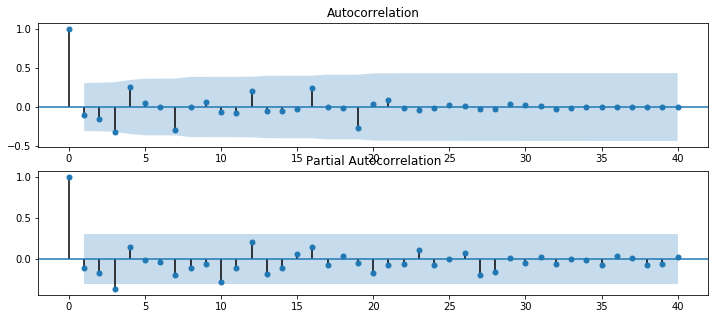

In [15]:
acf_pacf_fig(dis_use_train['C_used'].diff(1).dropna())#观察图形，可以看出C盘一阶差分数据适合采用AR（1），但偏自相关系数有反复现象，移动平均模型不能使用？

E:\Software\anaconda\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


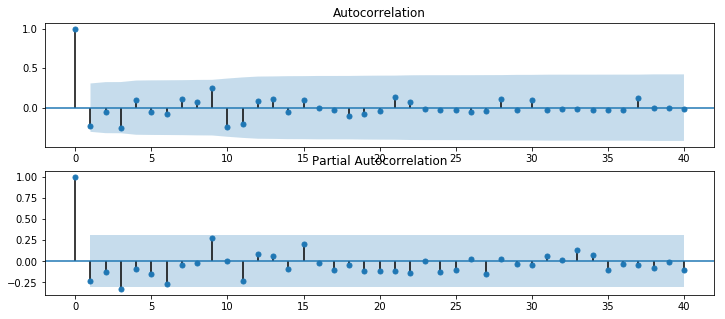

In [16]:
acf_pacf_fig(dis_use_train['D_used'].diff(1).dropna())#观察图形，可以看出D盘一阶差分数据适合采用AR（1）、MA（1）、ARMIA（1，1）

In [70]:
dis_use_train.index=dis_use_train['COLLECTTIME']#将时间作为索引，否则函数报错（没有时间）
#使用信息准则识别
from statsmodels.tsa.arima_model import ARIMA
def identify_model(time_data):
    pmax=int(len(time_data)/10)#一般阶数不能超过数据量的1/10
    qmax=int(len(time_data)/10)

    bic_matrix=[]
    aic_matrix=[]
    hqic_matrix=[]
    #循环寻找bic参数最优的p，q值
    for p in range(pmax+1):
        tmp1=[]
        tmp2=[]
        tmp3=[]
        for q in range(qmax+1):
            try:
                tmp1.append(ARIMA(time_data,(p,1,q)).fit().bic)
            except:
                tmp1.append(None)
            try:
                tmp2.append(ARIMA(time_data,(p,1,q)).fit().aic)
            except:
                tmp2.append(None)
            try:
                tmp3.append(ARIMA(time_data,(p,1,q)).fit().hqic)
            except:
                tmp3.append(None)
        bic_matrix.append(tmp1)
        aic_matrix.append(tmp2)
        hqic_matrix.append(tmp3)
    bic_matrix=pd.DataFrame(bic_matrix)
    aic_matrix=pd.DataFrame(aic_matrix)
    hqic_matrix=pd.DataFrame(hqic_matrix)
    p1,q1=bic_matrix.stack().astype('float64').idxmin()#先将bic_matrix展平，在用idxmin找出bic最小的p、q值
    p2,q2=aic_matrix.stack().astype('float64').idxmin()#先将bic_matrix展平，在用idxmin找出bic最小的p、q值
    p3,q3=hqic_matrix.stack().astype('float64').idxmin()#先将bic_matrix展平，在用idxmin找出bic最小的p、q值
    print('bic最小时，p和q值分别是%s、%s;aic最小时，p和q值分别是%s、%s;hqic最小时，p和q值分别是%s、%s' %(p1,q1,p2,q2,p3,q3))

In [71]:
identify_model(dis_use_train['C_used'])#若用bic准则，C盘数据不适合用arima模型，q和q均为0；用aic和hqic准则，应为arima(0,1,3)

bic最小时，p和q值分别是0、0;aic最小时，p和q值分别是0、3;hqic最小时，p和q值分别是0、3


In [72]:
identify_model(dis_use_train['D_used'])#D盘数据p和q应为1和1

bic最小时，p和q值分别是1、1;aic最小时，p和q值分别是0、3;hqic最小时，p和q值分别是1、1


# 模型检验（残差是否为白噪声）

C盘：ARIMA（0,1,3）；D盘ARIMA（0,1,3）或者ARIMA（1,1,1）

法一：德宾-沃森（Durbin-Watson）检验。德宾-沃森检验,简称D-W检验，是目前检验自相关性最常用的方法，但它只使用于检验一阶自相关性。因为自相关系数ρ的值介于-1和1之间，所以:

0≤DW≤４。并且DW＝O＝＞ρ＝１　　 即存在正自相关性
DW＝４＜＝＞ρ＝－１　即存在负自相关性
DW＝２＜＝＞ρ＝０　　即不存在（一阶）自相关性
因此，当DW值显著的接近于0或４时，则存在自相关性，而接近于2时，则不存在（一阶）自相关性。这样只要知道ＤＷ统计量的概率分布，在给定的显著水平下，根据临界值的位置就可以对原假设H0进行检验。

法二：观察是否符合正态分布
用QQ图，它用于直观验证一组数据是否来自某个分布，或者验证某两组数据是否来自同一（族）分布。在教学和软件中常用的是检验数据是否来自于正态分布。

法三：python的acorr_ljungbox函数

In [138]:
?acorr_ljungbox

In [73]:
#C盘数据：arima(0,1,3)模型
arima_C=ARIMA(dis_use_train['C_used'],(0,1,3)).fit()#模型训练
predict_C=arima_C.predict(typ='levels')#预测
error_C=(predict_C-dis_use_train['C_used']).dropna()#计算残差
diagnoise_test(error_C)#残差序列为白噪声，模型通过检验

序列为白噪声序列，对应p值为0.9013070981135178


In [74]:
#D盘数据：arima(1,1,1)模型
arima_d1=ARIMA(dis_use_train['D_used'],(1,1,1)).fit()#模型训练
predict_d1=arima_d1.predict(typ='levels')#预测
error_d1=(predict_d1-dis_use_train['D_used']).dropna()#计算残差
diagnoise_test(error_d1)#残差序列为白噪声，模型通过检验

序列为白噪声序列，对应p值为0.6698350964894465


In [75]:
#D盘数据：arima(0,1,3)模型
arima_d2=ARIMA(dis_use_train['D_used'],(0,1,3)).fit()#模型训练
predict_d2=arima_d2.predict(typ='levels')#预测
error_d2=(predict_d2-dis_use_train['D_used']).dropna()#计算残差
diagnoise_test(error_d2)#残差序列为白噪声，模型通过检验

序列为白噪声序列，对应p值为0.9541607334741714


In [ ]:
#DW检验
print(sm.stats.durbin_watson(arima_C.resid.values))
print(sm.stats.durbin_watson(arima_d1.resid.values))
print(sm.stats.durbin_watson(arima_d2.resid.values))

In [ ]:
#QQ图
qqplot(arima_C.resid, line='q', fit=True)
plt.show()

# 模型预测

In [110]:
dis_use_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 4 columns):
COLLECTTIME    47 non-null datetime64[ns]
C_used         47 non-null float64
D_used         47 non-null float64
pred           0 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5 KB


In [130]:
?arima.predict#根据起始时间进行预测

In [131]:
#C盘
c_pred_last=arima_C.predict(start='2014-11-12',end='2014-11-16',typ='levels')#预测
c_predict_final=predict_C.append(c_pred_last)
c_predict_final[len(c_predict_final)-5:]

2014-11-12    3.577997e+07
2014-11-13    3.583694e+07
2014-11-14    3.588960e+07
2014-11-15    3.593543e+07
2014-11-16    3.598126e+07
dtype: float64

In [132]:
#D盘ARIMA（1,1,1）
d_pred_last_1=arima.predict(start='2014-11-12',end='2014-11-16',typ='levels')#预测
d_predict_final_1=predict_d1.append(d_pred_last_1)
d_predict_final_1[len(d_predict_final_1)-5:]

2014-11-12    8.764336e+07
2014-11-13    8.769776e+07
2014-11-14    8.781214e+07
2014-11-15    8.794838e+07
2014-11-16    8.809259e+07
dtype: float64

In [133]:
#D盘ARIMA（0,1,3）
d_pred_last_2=arima_1.predict(start='2014-11-12',end='2014-11-16',typ='levels')#预测
d_predict_final_2=predict_d2.append(d_pred_last_2)
d_predict_final_2[len(d_predict_final_2)-5:]

2014-11-12    8.736074e+07
2014-11-13    8.726128e+07
2014-11-14    8.726070e+07
2014-11-15    8.738481e+07
2014-11-16    8.750893e+07
dtype: float64

# 模型评价

In [101]:
dis_use_t['COLLECTTIME']=pd.to_datetime(dis_use_t['COLLECTTIME'].astype(str),format='%Y-%m-%d')
dis_use_t.index=dis_use_t['COLLECTTIME']
dis_use_t.head()

,COLLECTTIME,C_used,D_used
COLLECTTIME,,,
2014-10-01,2014-10-01,34270787.33,80262592.65
2014-10-02,2014-10-02,34328899.02,83200151.65
2014-10-03,2014-10-03,34327553.50,83208320.00
2014-10-04,2014-10-04,34288672.21,83099271.65
2014-10-05,2014-10-05,34190978.41,82765171.65


In [134]:
dis_use_t['C_pred']=c_predict_final
dis_use_t['D_pred_1']=d_predict_final_1
dis_use_t['D_pred_2']=d_predict_final_2
dis_use_t.tail()

,COLLECTTIME,C_used,D_used,C_pred,D_pred_1,D_pred_2
COLLECTTIME,,,,,,
2014-11-12,2014-11-12,35704312.58,87249335.55,3.577997e+07,8.764336e+07,8.736074e+07
2014-11-13,2014-11-13,35704980.73,86986142.20,3.583694e+07,8.769776e+07,8.726128e+07
2014-11-14,2014-11-14,34570385.45,86678240.00,3.588960e+07,8.781214e+07,8.726070e+07
2014-11-15,2014-11-15,34673820.69,89766600.00,3.593543e+07,8.794838e+07,8.738481e+07
2014-11-16,2014-11-16,34793245.31,89377527.25,3.598126e+07,8.809259e+07,8.750893e+07


In [106]:
#计算三个效果指标：平均绝对误差、均方误差、平均百分比误差
def evaluate(original,predict,c_d):
    abs_=(original-predict).abs()
    mae=abs_.mean()
    rmse=((abs_**2).mean())**0.5
    mape=(abs_/dis_use_t[c_d]).mean()
    print('平均绝对误差、均方误差、平均百分比误差分别为:%0.4f,%0.4f,%0.6f' %(mae,rmse,mape))

In [135]:
evaluate(dis_use_t['C_used'],dis_use_t['C_pred'],'C_used')
#综合三个指数来看，D盘数据应采用ARIMA（0,1,3）
evaluate(dis_use_t['D_used'],dis_use_t['D_pred_1'],'D_used')
evaluate(dis_use_t['D_used'],dis_use_t['D_pred_2'],'D_used')

平均绝对误差、均方误差、平均百分比误差分别为:237984.8594,427470.7866,0.006886
平均绝对误差、均方误差、平均百分比误差分别为:846789.5976,1130839.2416,0.009974
平均绝对误差、均方误差、平均百分比误差分别为:793275.9715,1128947.5176,0.009316


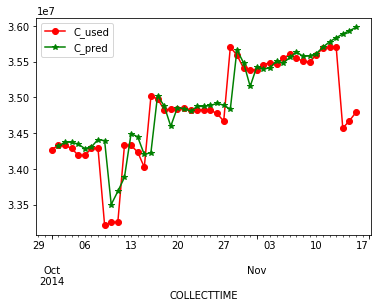

In [136]:
dis_use_t[['C_used','C_pred']].plot(style=['r-o','g-*'])
plt.show()#前期拟合地还行，但是后期预测阶段突发性变化表现差，主要是因为移动平均模型的滞后反应

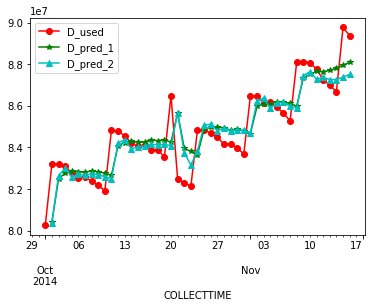

In [137]:
dis_use_t[['D_used','D_pred_1','D_pred_2']].plot(style=['r-o','g-*','c-^'])
plt.show()#两种模型前期几乎没有什么差别，后期ARIMA（0,1,3）低于ARIMA（1,1,1），虽然从评价指标上来看，前者比后者效果好，但从趋势上看，后者似乎更好